## Tree Models

In [1]:
import json
from tqdm import tqdm
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from features import feature_pipeline

In [33]:
import graphviz
import re
from sklearn.tree import export_graphviz

# From DSCI 571 Lab 1 Solutions
def display_tree(feature_names, tree, save=False, save_name="tree"):
    """ For binary classification only """
    dot = export_graphviz(
        tree,
        out_file=None,
        feature_names=feature_names,
        class_names=tree.classes_.astype(str),
        impurity=False,
    )
    # adapted from https://stackoverflow.com/questions/44821349/python-graphviz-remove-legend-on-nodes-of-decisiontreeclassifier
    dot = re.sub("(\\\\nsamples = [0-9]+)(\\\\nvalue = \[[0-9]+, [0-9]+\])", "", dot)
    dot = re.sub("(samples = [0-9]+)(\\\\nvalue = \[[0-9]+, [0-9]+\])\\\\n", "", dot)
    if save:
        graph = graphviz.Source(dot)
        graph.render(save_name)
    return graphviz.Source(dot)

#### Data Loading

In [2]:
with open("../data/train.json", "r") as f:
    train = json.load(f)
with open("../data/val.json", "r") as f:
    val = json.load(f)

In [3]:
pipe = feature_pipeline()

#### Build Feature Matrices

In [4]:
X_train = []
y_train = []
for ex in tqdm(train, desc="Building Training Data"):
    features, _ = pipe.feature_extractor(ex["content"])
    X_train.append(features)
    y_train.append(ex["level"][0])

Building Validation Data: 100%|████████████████████████████████████████████| 31/31 [03:12<00:00,  6.20s/it]


In [10]:
X_val = []
y_val = []
for ex in tqdm(val, desc="Building Validation Data"):
    features, labels = pipe.feature_extractor(ex["content"])
    X_val.append(features)
    y_val.append(ex["level"][0])

Building Validation Data: 100%|████████████████████████████████████████████| 31/31 [01:27<00:00,  2.83s/it]


In [11]:
X_train = pd.DataFrame(X_train, columns=labels)
X_val = pd.DataFrame(X_val, columns=labels)

In [15]:
print(
    f"All features:\n{list(X_train.columns)}\n\nNumber of features: {len(X_train.columns)}"
)

All features:
['total_tokens', 'total_tokens_w/o_stopwords', 'avg_sent_length', 'proportion_of_a_level_tokens', 'proportion_of_a_level_types', 'ttr', 'avg_rank_of_lemmas_in_freq_list', 'fernandez_huerta_score', 'syllables_per_sentence', 'ADJ', 'ADP', 'ADV', 'AUX', 'CONJ', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X', 'EOL', 'SPACE', 'CONTENT', 'FUNCTION']

Number of features: 31


In [13]:
print(X_train)

     total_tokens  total_tokens_w/o_stopwords  avg_sent_length  \
0             294                         124        21.000000   
1            1804                         694        11.895425   
2             301                         132         7.166667   
3            2153                         869        61.514286   
4            1621                         654         9.210227   
..            ...                         ...              ...   
272            76                          34        25.333333   
273           196                          83        28.000000   
274           203                          86        25.375000   
275           401                         193        21.105263   
276           358                         160        27.538462   

     proportion_of_a_level_tokens  proportion_of_a_level_types       ttr  \
0                        0.346774                     0.239130  0.472789   
1                        0.358790                     0

#### Determine the appropriate depth for the decision tree classifier

In [66]:
depths = range(1, 21)

train_accuracies = []
val_accuracies = []

for depth in depths:
    predictions = []
    tree = DecisionTreeClassifier(random_state=123, max_depth=depth)
    tree.fit(X_train, y_train)
    train_accuracies.append(tree.score(X_train, y_train))
    predicted_y_val = tree.predict(X_val, y_val)
    val_accuracies.append(accuracy_score(y_val, predicted_y_val))

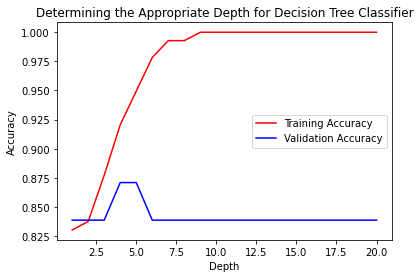

In [67]:
import matplotlib.pyplot as plt

plt.plot(depths, train_accuracies, "r")
plt.plot(depths, val_accuracies, "b")
plt.title("Determining the Appropriate Depth for Decision Tree Classifier")
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.show()

In [68]:
depth = 5
print(f"Training decision tree classifier with max depth of {depth} ...\n")
tree = DecisionTreeClassifier(random_state=16, max_depth=depth)
tree.fit(X_train, y_train)
print("Training accuracy %0.3f" % (tree.score(X_train, y_train)))

Training decision tree classifier with max depth of 5 ...

Training accuracy 0.949


In [69]:
predicted_y_val = tree.predict(X_val, y_val)
print("Validation accuracy %0.3f" % (accuracy_score(y_val, predicted_y_val)))

Validation accuracy 0.871


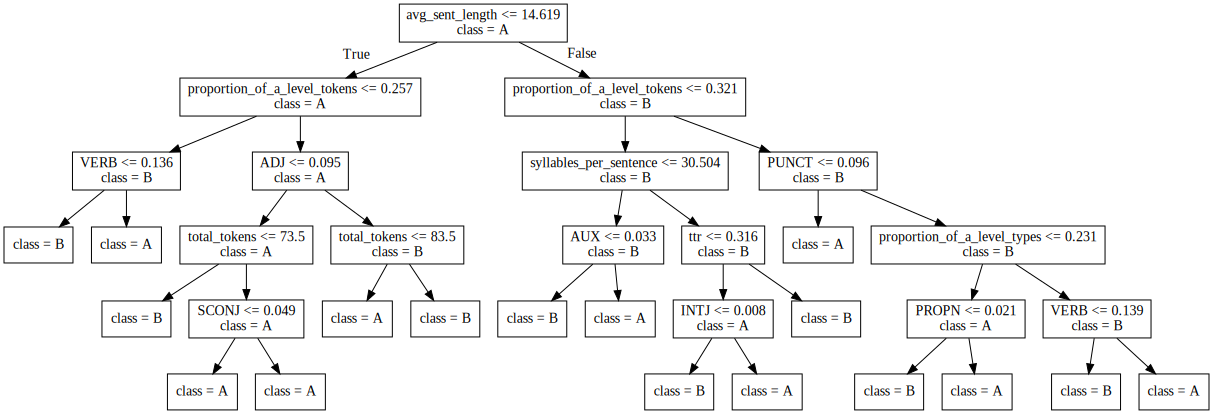

In [70]:
display_tree(X_train.columns, tree, save=True)

#### Let's try some more advanced tree models too

In [71]:
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [72]:
classifiers = {
    "random forest": RandomForestClassifier(random_state=123),
    "XGBoost": XGBClassifier(random_state=123),
    "LightGBM": LGBMClassifier(random_state=123),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=123),
}

for (name, model) in classifiers.items():
    model.fit(X_train, y_train)
    print(name)
    print("Training accuracy %0.3f" % (model.score(X_train, y_train)))
    predicted_y_val = model.predict(X_val)
    print("Validation accuracy %0.3f" % (accuracy_score(y_val, predicted_y_val)))
    print()

random forest
Training accuracy 1.000
Validation accuracy 0.903

[18:10:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rsss9\miniconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBoost
Training accuracy 1.000
Validation accuracy 0.903

LightGBM
Training accuracy 1.000
Validation accuracy 0.935

CatBoost
Training accuracy 1.000
Validation accuracy 0.935

